## Project 2: Road Segmentation of Satellite images with CNN

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, glob, re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from PIL import Image
import torch
import torch.nn as nn
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import *

import torchvision
import torchvision.transforms as T
from torchvision import models

In [2]:
# local imports
from utils.helpers import *
from cnn import *
from dataset import *
from submissions import *

In [3]:
if torch.cuda.is_available():
    print("Name of the Graphics card", torch.cuda.get_device_name())
    print("Number of GPU available", torch.cuda.device_count())
    device = "cuda"
else:
    print("No GPU available on this machine")
    device = "cpu"

No GPU available on this machine


#### Loading images and groundtruths

In [4]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
#n = min(30, len(files))
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


Text(0.5, 1.0, 'real and groundtruth images')

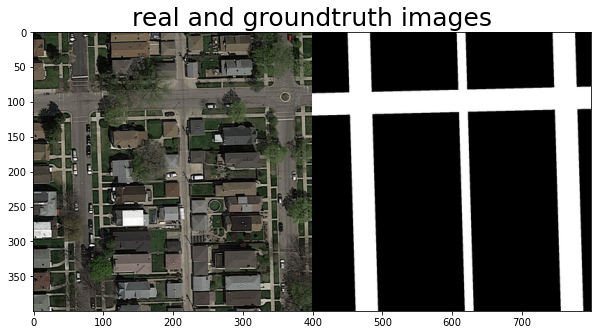

In [5]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.title("real and groundtruth images", fontdict={'fontsize':25})

#### Extracting image patches and their label

In [6]:
# Extract patches and labels
patch_size = 16
window_size = 64
padding = (window_size - patch_size) // 2
img_patches, Y = extract_patches_labels(imgs, gt_imgs, patch_size, padding, n)

# Mean and std of our dataset of image patches
mean_img = np.mean(img_patches, axis=(0, 1, 2))
std_img = np.std(img_patches, axis=(0, 1, 2))



#### Training and Validation datasets

In [7]:
# Trainset and Validation sets
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train, mean_img, std_img), batch_size=batch_size, sampler=sampler)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid, mean_img, std_img), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))

Dealing with imbalanced datasets
Background weight: 0.676
Road weight: 1.922
Number of patches in the training dataset: 50000
Number of patches in the validation dataset: 12500


## Training the CNN

In [8]:
# hyperparameters
num_epochs = 100
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

#### Performance of the Model without Data Augmentation

In [10]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs, device)
plot_performance(loss_train, loss_valid)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Starting training


  1%|▉                                                                                 | 3/250 [00:08<12:15,  2.98s/it]


KeyboardInterrupt: 

#### Performance of the Model with Data Augmentation

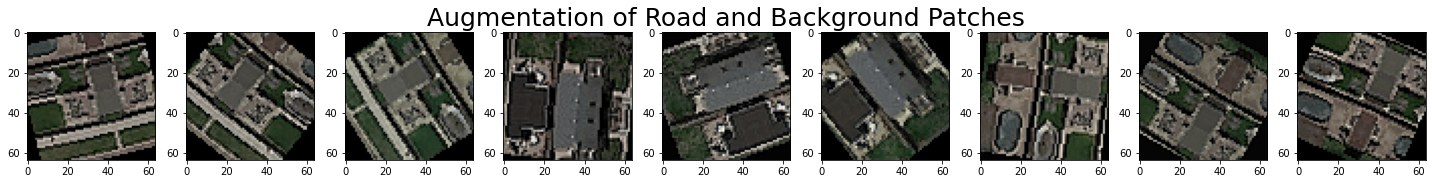

In [11]:
# Visualize possible augmentations for road and background patches from the Training dataset
ind_patches = [10, 5, 9]
fig, ax = plt.subplots(1, 3*len(ind_patches), figsize=(20, 20))
for i in range (3):
    for j in range (len(ind_patches)):
        ax[i + 3*j].imshow(augmentation(img_patches[ind_patches[j]]).permute(1, 2, 0).numpy())

ax[4].set_title("Augmentation of Road and Background Patches", fontdict={'fontsize':25})
plt.tight_layout()

In [12]:
# Augmented Training dataset and validation set
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
trainsetAugmented = TrainsetCNN(img_train, Y_train, mean_img, std_img, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

validset = TrainsetCNN(img_valid, Y_valid, mean_img, std_img)
dataset_valid = DataLoader(validset, batch_size=batch_size, shuffle=True)

Dealing with imbalanced datasets
Background weight: 0.675
Road weight: 1.930


In [13]:
# Training the CNN on the Augmented Dataset
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs, device)
plot_performance(loss_train, loss_valid)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Starting training


  1%|▋                                                                                 | 2/250 [00:06<13:50,  3.35s/it]


KeyboardInterrupt: 

#### Prediction of the CNN for one test image

Text(0.5, 1.0, 'Test Image 1')

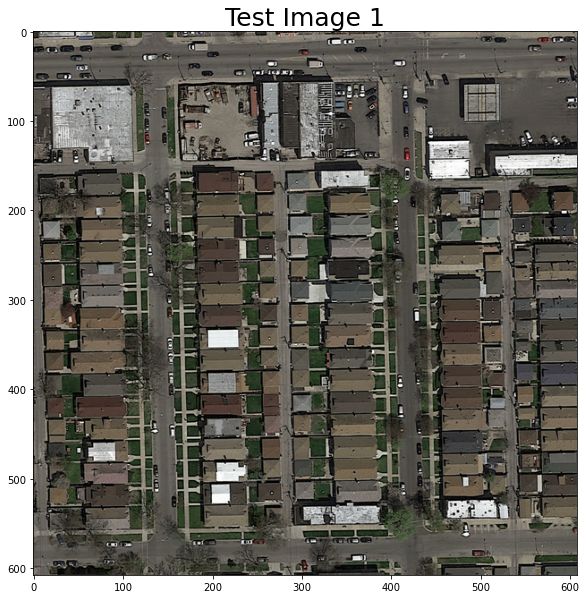

In [14]:
# Load all test images
test_images = list(glob.iglob(image_test + '/*/*.png', recursive=True))

# Extract one test image for visualization
test_1_path = test_images[0]
test_1 = load_image(test_1_path)

# show test image 1
plt.figure(figsize=(10, 10))
plt.imshow(test_1)
plt.title("Test Image 1", fontdict={'fontsize':25})

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


True positive rate = 0.0


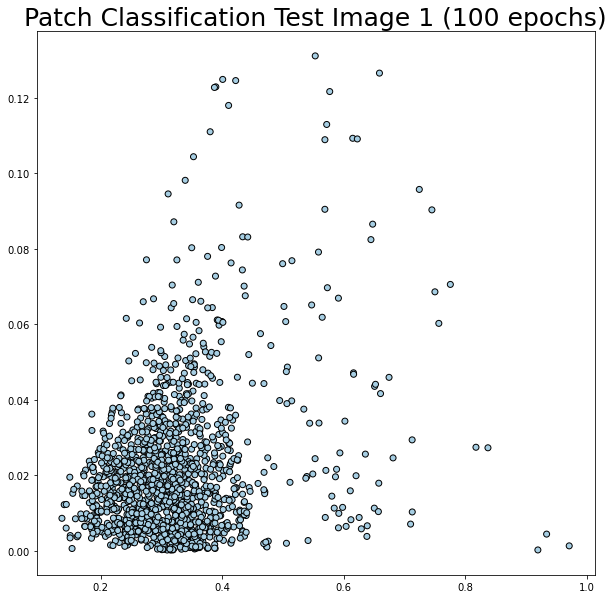

In [15]:
# Test set of image patches
patches_test = np.array(img_crop(test_1, patch_size, padding))
dataset_test = torch.utils.data.DataLoader(TestsetCNN(patches_test, mean_img, std_img), batch_size=batch_size, shuffle=False)

# Running the prediction for the test image
Zi = predict(model_lenet, dataset_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
patches_test_2D = extract_img_features(test_1_path, patch_size)
plt.figure(figsize=(10, 10))
plt.scatter(patches_test_2D[:, 0], patches_test_2D[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Patch Classification Test Image 1 ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.show()

C:\Users\galan\Google Drive\cours EPFL\ML\ML-Project-2\src\utils\helpers.py:14: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)


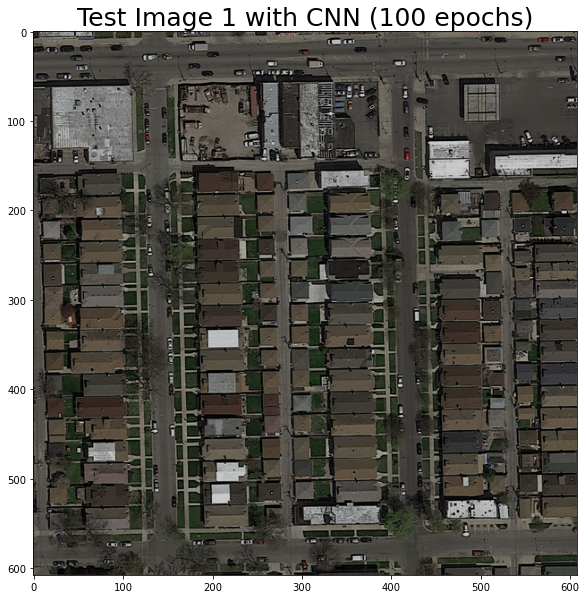

In [16]:
# Display prediction as an image

w = test_1.shape[0]
h = test_1.shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(test_1, predicted_im)
plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_1, predicted_im)

plt.title("Test Image 1 with CNN ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.imshow(new_img)

## Generating the predictions for the submission

In [17]:
# hyperparameters
num_epochs = 100
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [18]:
# Building the augmented training set
batch_size = 200
sampler = balanced_sampler(Y)
trainsetAugmented = TrainsetCNN(img_patches, Y, mean_img, std_img, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

Dealing with imbalanced datasets
Background weight: 0.675
Road weight: 1.930


In [19]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
train_submissions(model_lenet, criterion, dataset_train, optimizer, num_epochs, device)

  0%|                                                                                          | 0/313 [00:00<?, ?it/s]

Starting training


  1%|▌                                                                                 | 2/313 [00:07<19:22,  3.74s/it]


KeyboardInterrupt: 

In [20]:
test_files = list(glob.iglob(image_test + '/*/*.png', recursive=True))
masks_to_submission(model_lenet, "submission.csv", test_files, patch_size, padding, mean_img, std_img)

  4%|███▎                                                                               | 2/50 [00:18<07:21,  9.19s/it]


KeyboardInterrupt: 